## Example panan-rOM3 analysis notebook - modified for SWMT

For `8km_jra_ryf_obc_Charrassin` experiment (MOM6-CICE6 panan 1/12th degree ~ 4km with no ice shelves)

**Note** Several non-standard uses of `esm_datastore`:

- `esm_datastore` was generated with a different branch to main to pick up incorrectly named files (see https://github.com/ACCESS-NRI/access-nri-intake-catalog/issues/459, thanks to Charles Turner for fixing this for me)
- Years 9 and 10 of this run used parallelised IO, and unfortunately the tiling resulted in NaNs along part of the y axis in these files. Therefore, we must use a preprocessing function that replaces these axes with that of an earlier time (month 0) (thanks to Jemma Jeffree for her help with this!)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
import intake
import cmocean as cm
import gsw

import os
import pathlib
import shutil

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 510.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38339,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34439,Total threads: 1
Dashboard: /proxy/46411/status,Memory: 36.43 GiB
Nanny: tcp://127.0.0.1:35501,


Load datastore

In [3]:
esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/archive/8km_jra_ryf_obc_Charrassin/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

# esm_datastore

List available diagnostics

In [4]:
variables = esm_datastore.unique().variable
print(variables)

['ANGLE', 'ANGLET', 'NCAT', 'VGRDa', 'VGRDb', 'VGRDi', 'VGRDs', 'aice', 'blkmask', 'congel', 'dvidtd', 'dvidtt', 'frazil', 'frzmlt', 'hi', 'hs', 'sifb', 'snoice', 'time', 'time_bounds', 'uvel', 'vvel', 'Tair_m', 'Tsfc_m', 'aice_m', 'aicen_m', 'albice_m', 'albsni_m', 'albsno_m', 'alidf_ai_m', 'alidr_ai_m', 'alvdf_ai_m', 'alvdr_ai_m', 'congel_m', 'daidtd_m', 'daidtt_m', 'divu_m', 'dvidtd_m', 'dvidtt_m', 'evap_ai_m', 'fcondtop_ai_m', 'fcondtopn_ai_m', 'fhocn_ai_m', 'flat_ai_m', 'flatn_ai_m', 'flwdn_m', 'flwup_ai_m', 'fmeltt_ai_m', 'fmelttn_ai_m', 'frazil_m', 'fresh_ai_m', 'frzmlt_m', 'fsalt_ai_m', 'fsalt_m', 'fsens_ai_m', 'fsensn_ai_m', 'fsurfn_ai_m', 'fswabs_ai_m', 'fswdn_m', 'fswthru_ai_m', 'fswup_m', 'hi_m', 'hs_m', 'ice_present_m', 'meltb_m', 'meltl_m', 'melts_m', 'meltt_m', 'opening_m', 'rain_ai_m', 'scale_factor_m', 'shear_m', 'sice_m', 'sifb_m', 'snoice_m', 'snow_ai_m', 'strairx_m', 'strairy_m', 'strcorx_m', 'strcory_m', 'strength_m', 'strintx_m', 'strinty_m', 'strocnx_m', 'strocny

Load month 0 specific datastore to get y axis info

In [5]:
mo0_esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/datastores/8km_jra_ryf_obc_Charrassin-output000/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

ds_good_yh = mo0_esm_datastore.search(variable="umo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yh_coords = ds_good_yh.yh.copy().load()
ds_good_yq = mo0_esm_datastore.search(variable="vmo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yq_coords = ds_good_yq.yq.copy().load()
def reset_y_coords(ds): #thanks to Jemma Jeffree for helping make this work!!
    ds = ds.assign_coords({'yh':good_yh_coords})
    ds = ds.assign_coords({'yq':good_yq_coords})
    return ds

When loading data that has a y-axis, you need to use the `preprocess` (and likely `decode_timedelta` too) arguments:
```
esm_datastore.search(variable="").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})
```



In [6]:
# Make sure these match the available restarts:
start_time='1908-01-01'
end_time='1910-12-31'
time_slice = slice(start_time,end_time)
lat_slice  = slice(-80,-59)
lon_slice  = slice(-280,80)

outpath = '/g/data/gv90/fbd581/access-om3-iceshelves/mom6-panAn-iceshelf-tools/Hackathon_evaluation/Figures/'

## Doing SWMT: 

### it didn't work (took forever) here so I run it via PBS quere here:

- /g/data/gv90/fbd581/access-om3-iceshelves/mom6-panAn-iceshelf-tools/Hackathon_evaluation/mom6-panAn-iceshelf-tools/evaluation
- submit_SWMT_mom6.sh, calling SWMT_mom6.py
- results were saved here:
  - /g/data/gv90/fbd581/access-om3-iceshelves/swmt/binned_salt_transformation_mom6-8km.nc
  - /g/data/gv90/fbd581/access-om3-iceshelves/swmt/binned_heat_transformation_mom6-8km.nc

In [7]:
def get_variables(expt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6'):

    # The models require different diagnostics to calculate the heat and salt fluxes.
    # mom6 outputs a net flux, whilst with mom5 we need to work with the separate components.
    model_vars = {
                    "mom6": {
                        "temperature":           ["thetao"],
                        "salinity":              ["so"],
                        "water_flux_into_ocean": ["wfo"],
                        "salt_flux":             ["salt_flux"],
                        "heat_flux":             ["hfds"],
                        "area":                  ["areacello"],
                        "maximum_depth":         ["deptho"],
                    }
                }
    # Load variables in a dictionary
    ds = {}
    keys = list(model_vars[model].keys())
    for k in keys:
        ds[k] = {}
        for var in model_vars[model][k]:
            if var=='wfo':
                fileid='access_om3_mom6_2d_wfo_1mon_mean_XXXX'
            elif var=='hfds':
                fileid='access_om3_mom6_2d_hfds_1mon_mean_XXXX'
            elif var=='salt_flux':
                fileid='ocean_month'
            elif var=='areacello' or var=='deptho':
                fileid='access_om3_mom6_static'
            elif var=='thetao' or var=='so':
                fileid='ocean_month_z'
        
            ds[k][var] = esm_datastore.search(variable=var, file_id=fileid).to_dask(
                preprocess=reset_y_coords,xarray_open_kwargs={"chunks": {"time": 1}, 'decode_timedelta':True})[var]        
                # preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})[var]                    
            if k in ["area", "maximum_depth"]:
                ds[k][var] = ds[k][var].sel(xh = lon_slice, yh = lat_slice)
            else:
                ds[k][var] = ds[k][var].sel(xh = lon_slice, yh = lat_slice, time = slice(start_time, end_time))
            
            # Correct temperatures (if in K convert to C)
            if k == 'temperature' and np.max(ds[k][var]) > 100:
                ds[k][var] = ds[k][var] - 273.15

            # If 3D field, grab the surface
            if 'z_l' in ds[k][var].dims:
                surface_z = ds[k][var]['z_l'][0].values
                ds[k][var] = ds[k][var].sel(z_l = 0, method = 'nearest')

    # Get temperature and salinity to calculate few other things we'll need later on
    SP = ds['salinity'][model_vars[model]['salinity'][0]]
    CT = ds['temperature'][model_vars[model]['temperature'][0]]

    # Calculate pressure
    pressure = gsw.p_from_z(-surface_z, SP['yh']).rename('pressure')

    # Calculate absolute salinity
    SA = gsw.SA_from_SP(SP, pressure, SP['xh'], SP['yh']).rename('SA')

    # Ensure we have conservative temperature; Convert MOM6's potential temperature to conservative
    if model == 'mom6':
        CT = gsw.CT_from_pt(SA, CT)
        ds['temperature'][model_vars[model]['temperature'][0]].data = CT.values

    # Calculate potential density
    pot_rho_1 = gsw.sigma1(SA, CT)#.rename('pot_rho_11')

    # Save everything to our dictionary
    ds['pressure'] = pressure
    ds['SA'] = SA
    ds['pot_rho_1'] = pot_rho_1
    
    # Calculate days per month accounting for leap years
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    months_standard_leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if 'ryf' or 'panan' in expt:
        nyears = len(np.unique(CT['time.year']))
        days_per_month = np.tile(months_standard_noleap, nyears)
    elif 'iaf' in expt:
        nyears = len(np.unique(CT['time.year']))
        if CT['time.year'][0] % 4 == 0:
            days_per_month = months_standard_leap
        else: 
            days_per_month = months_standard_noleap
        for yr in CT['time.year'][::12][1:]:
            if yr % 4 == 0:
                days_per_month = np.concatenate([days_per_month, months_standard_leap])
            else:
                days_per_month = np.concatenate([days_per_month, months_standard_noleap])
    days_per_month = xr.DataArray(days_per_month, dims = ['time'], coords = {'time': CT['time']}, name = 'days_per_month')
    ds['days_per_month'] = days_per_month

    return ds

In [8]:
# ds = get_variables(esm_datastore, '1mon', start_time, end_time, lon_slice, lat_slice, model = 'mom6')


In [9]:
def compute_salt_transformation(ds):
    
    # First retrieve temperature and water_flux as an xarray instead of a dictionary
    CT = xr.Dataset(ds['temperature']).to_array().squeeze().drop_vars('variable')

    # Multiply the water flux by absolute salinity to get it in the correct units
    water_flux_into_ocean = xr.Dataset(ds['water_flux_into_ocean']).to_array().squeeze().drop_vars('variable')
    water_flux_into_ocean = ds['SA'] * water_flux_into_ocean

    # Caculate the haline contraction coefficient
    haline_contraction = gsw.beta(ds['SA'], CT, ds['pressure']).rename('beta')

    # Calculate the net salt flux and multiply by 1000 to convert units
    net_salt_flux = xr.Dataset(ds['salt_flux']).to_array().sum(dim = 'variable') * 1000

    # Note that we also multiply pme_river by absolute salinity to have the correct units
    salt_transformation = haline_contraction * (water_flux_into_ocean - net_salt_flux) * ds['days_per_month']
    salt_transformation = salt_transformation.load()

    return salt_transformation

def compute_heat_transformation(ds):

    # First retrieve temperature as an xarray instead of a dictionary
    CT = xr.Dataset(ds['temperature']).to_array().squeeze().drop_vars('variable')

    # Calculate the thermal expansion coefficient 
    thermal_expansion = gsw.alpha(ds['SA'], CT, ds['pressure']).rename('alpha')
    
    # Calculate the net surface heating
    net_surface_heating = xr.Dataset(ds['heat_flux']).to_array().sum(dim = 'variable')
    
    # Calculate the heat transformation
    heat_transformation = thermal_expansion * net_surface_heating * ds['days_per_month']
    heat_transformation = heat_transformation.load()

    return heat_transformation

In [10]:
def isopycnal_bins(ds, salt_transformation, heat_transformation):

    # Next section does a few things. It cycles through isopycnal bins, determines which cells are 
    # within the given bin for each month, finds the transformation values for those cells for each month, 
    # and sums these through time. You are left with an array of shape (isopyncal bins * lats * lons) 
    # where the array associated with a given isopycnal bin is NaN everywhere except where pot_rho_1 
    # was within the bin, there it has a time summed transformation value.
    
    # Choose appropriate bin range
    isopycnal_bins = np.arange(31, 33.5, 0.02)  # 125 bins - 31, 33.5, 0.02 (sigma1)
    #isopycnal_bins = np.concatenate([np.arange(25.0, 26.5, 0.05), np.arange(26.5, 28.5, 0.02)])  # 130 bins (sigma0)
    bin_bottoms = isopycnal_bins[:-1]
    isopycnal_bin_mid = (isopycnal_bins[1:] + bin_bottoms) / 2
    isopycnal_bin_diff = np.diff(isopycnal_bins)

    pot_rho_1 = ds['pot_rho_1']

    results_salt = []
    results_heat = []

    for i in range(len(bin_bottoms)):
        # Create binary mask for each bin
        bin_mask = xr.where((pot_rho_1 > bin_bottoms[i]) & (pot_rho_1 <= isopycnal_bins[i + 1]), 1, np.nan)

        # Multiply and sum over time
        salt_sum = (salt_transformation * bin_mask).sum(dim='time')
        heat_sum = (heat_transformation * bin_mask).sum(dim='time')

        results_salt.append(salt_sum.expand_dims({'isopycnal_bins': [isopycnal_bin_mid[i]]}))
        results_heat.append(heat_sum.expand_dims({'isopycnal_bins': [isopycnal_bin_mid[i]]}))

    # Concatenate results along isopycnal dimension
    salt_transformation = xr.concat(results_salt, dim='isopycnal_bins')
    heat_transformation = xr.concat(results_heat, dim='isopycnal_bins')

    # Normalise by number of days and bin thickness
    ndays = ds['days_per_month'].sum()
    c_p = 3992.1 # J kg-1 degC-1

    salt_transformation /= ndays
    heat_transformation /= (c_p * ndays)

    salt_transformation /= isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    heat_transformation /= isopycnal_bin_diff[:, np.newaxis, np.newaxis]

    # Overwrite zeros with NANs 
    # (Note: the code within the for-loop should provide nans but lazy computing with dask can sometimes give unpredictable results)
    salt_transformation = salt_transformation.where(salt_transformation != 0)
    heat_transformation = heat_transformation.where(heat_transformation != 0)

    # Change the sign so that positive means conversion into denser water masses
    salt_transformation *= -1
    heat_transformation *= -1

    # Renaming
    salt_transformation.name = "salt_transformation"
    heat_transformation.name = "heat_transformation"

    return salt_transformation.load(), heat_transformation.load()

In [11]:
# salt_transformation = compute_salt_transformation(ds)
# heat_transformation = compute_heat_transformation(ds)


In [12]:
# # Set temp_dir to a directory to store ~8GB of temporary output files
# temp_dir = os.path.expandvars("/g/data/gv90/fbd581/access-om3-iceshelves/swmt")
# temp_path = pathlib.Path(temp_dir)

# # Ensure a fresh start
# if temp_path.exists():
#     shutil.rmtree(temp_path)  # Delete the directory and all its contents
# temp_path.mkdir(parents=True, exist_ok=True)  # Create it again

In [13]:
# %%time
# salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)


In [14]:
# %%time
# salt_transformation_binned.to_netcdf(pathlib.Path(temp_dir, "binned_salt_transformation_mom6-8km.nc"), mode="w")


In [15]:
# %%time
# heat_transformation_binned.to_netcdf(pathlib.Path(temp_dir, "binned_heat_transformation_mom6-8km.nc"), mode="w")

In [16]:
# %%timeit -n 1 -r 1
# salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

# salt_transformation_binned.to_netcdf(pathlib.Path(temp_dir, "binned_salt_transformation_mom6-8km.nc"), mode="w")
# heat_transformation_binned.to_netcdf(pathlib.Path(temp_dir, "binned_heat_transformation_mom6-8km.nc"), mode="w")

### loading SWMT diagnostics:

In [17]:
# Choose appropriate bin range
isopycnal_bins = np.arange(31, 33.5, 0.02)  # 125 bins - 31, 33.5, 0.02 (sigma1)
bin_bottoms = isopycnal_bins[:-1]
isopycnal_bin_mid = (isopycnal_bins[1:] + bin_bottoms) / 2
isopycnal_bin_diff = np.diff(isopycnal_bins)


In [18]:
path = '/g/data/gv90/fbd581/access-om3-iceshelves/swmt/'
salt_ds = xr.open_dataset(path + 'binned_salt_transformation_mom6-8km_v2.nc')
salt_transformation = salt_ds.salt_transformation
salt_ds.close()
salt_transformation.load()


<xarray.DataArray 'salt_transformation' (isopycnal_bins: 124, yh: 744, xh: 4320)> Size: 3GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 992B 31.01 31.03 ... 33.45 33.47
  * xh              (xh) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96
    z_l             float64 8B 0.5413
  * yh              (yh) float64 6kB -79.98 -79.96 -79.94 ... -59.05 -59.01

In [19]:
heat_ds = xr.open_dataset(path + 'binned_heat_transformation_mom6-8km_v2.nc')
heat_transformation = heat_ds.heat_transformation
heat_ds.close()
heat_transformation.load()


<xarray.DataArray 'heat_transformation' (isopycnal_bins: 124, yh: 744, xh: 4320)> Size: 3GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 992B 31.01 31.03 ... 33.45 33.47
  * xh              (xh) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96
    z_l             float64 8B 0.5413
  * yh              (yh) float64 6kB -79.98 -79.96 -79.94 ... -59.05 -59.01

In [20]:
area = esm_datastore.search(variable='areacello').to_dask(
                preprocess=reset_y_coords,xarray_open_kwargs={"chunks": {"time": 1}, 'decode_timedelta':True})#[areacello]        

yh = esm_datastore.search(variable='yh', file_id='ocean_month').to_dask(
                preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})['yh']
yh = yh.sel(yh = slice(-90, -59))

xh = esm_datastore.search(variable='xh', file_id='ocean_month').to_dask(
                preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})['xh']        


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/source.py:280: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


In [21]:
ht = esm_datastore.search(variable='thkcello').to_dask(
                preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})['thkcello']    
ht = ht.sel(yh = slice(-90, -59)).isel(zl=0)
land_mask = (ht*0).fillna(1)
land_mask=land_mask.isel(time=slice(96,120)).mean('time')


In [22]:
# load contour from Wilton:

def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/x77/wf4500/MOM6_panan_ice_shelf/GH/mom6-panAn-iceshelf-tools/evaluation/isobath_1000m_8km_jra_ryf_obc_Charrassin.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yh', yh.values), ('xh', xh.values)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yh', yh.values), ('xh', xh.values)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yh = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map

In [23]:
area_shelf , shelf_mask = shelf_mask_isobath(area['areacello'])
heat_transformation_shelf, shelf_mask = shelf_mask_isobath(heat_transformation)
salt_transformation_shelf, shelf_mask = shelf_mask_isobath(salt_transformation)

In [24]:
# integrated over the Antarctic shelf: 
heat_ctrl_shelf_sum = (heat_transformation_shelf*area_shelf/1e6).sum(['xh', 'yh']).values
salt_ctrl_shelf_sum = (salt_transformation_shelf*area_shelf/1e6).sum(['xh', 'yh']).values


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 3.00 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 3.00 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [25]:
# integrated over the whole domain: 
heat_ctrl_sum = (heat_transformation*area['areacello']/1e6).sum(['xh', 'yh']).values
salt_ctrl_sum = (salt_transformation*area['areacello']/1e6).sum(['xh', 'yh']).values

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 2.97 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 2.97 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Text(0.5, 1.0, 'SWMT over the whole domain')

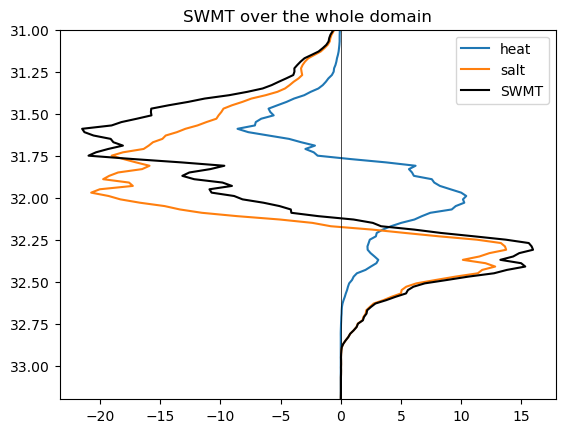

In [26]:
plt.plot(heat_ctrl_sum,isopycnal_bin_mid,label='heat')
plt.plot(salt_ctrl_sum,isopycnal_bin_mid,label='salt')
plt.plot(salt_ctrl_sum+heat_ctrl_sum,isopycnal_bin_mid,'-k',label='SWMT')
plt.legend()
plt.plot([0, 0],[31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
# plt.xlim([-15,15])
plt.title('SWMT over the whole domain')


Text(0.5, 0, 'Transformation rates (Sv)')

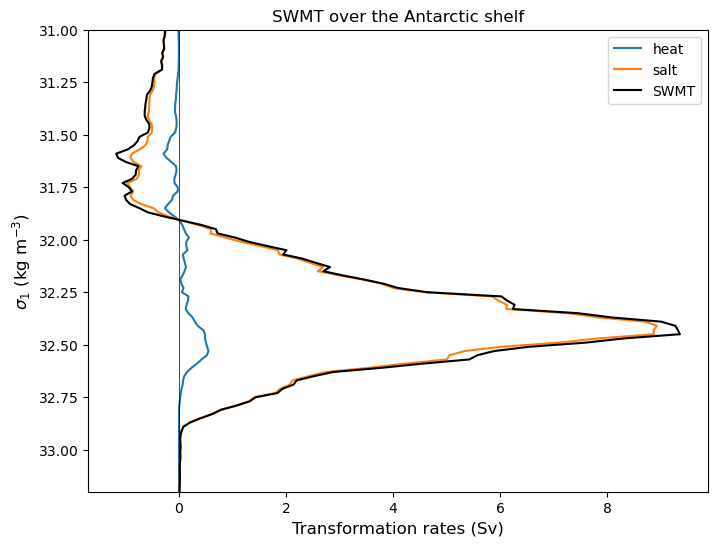

In [27]:
fig  = plt.figure(figsize = (8,6))

plt.plot(heat_ctrl_shelf_sum,isopycnal_bin_mid,label='heat')
plt.plot(salt_ctrl_shelf_sum,isopycnal_bin_mid,label='salt')
plt.plot(salt_ctrl_shelf_sum+heat_ctrl_shelf_sum,isopycnal_bin_mid,'-k',label='SWMT')
plt.legend()
plt.plot([0, 0],[31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
# plt.xlim([-8,8])
plt.title('SWMT over the Antarctic shelf')
plt.ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 12)
plt.xlabel(r'Transformation rates (Sv)', fontsize = 12)
# plt.grid('on')


#### SWMT maps:

In [28]:
swmt_ctrl_shelf_sum = salt_ctrl_shelf_sum+heat_ctrl_shelf_sum
swmt_ctrl_shelf =  salt_transformation_shelf+heat_transformation_shelf

max_transformation_index_ctrl = np.argmax(swmt_ctrl_shelf_sum)
max_transformation_density = isopycnal_bin_mid[max_transformation_index_ctrl]
print('Shelf subduction density:',max_transformation_density)

shelf_diff = (swmt_ctrl_shelf.isel(isopycnal_bins = max_transformation_index_ctrl)) #- swmt_Tfreezing_min_shelf.isel(isopycnal_bins = max_transformation_index_Tfreezing_min) )
#shelf_subduction_plot = swmt_ctrl_shelf.isel(isopycnal_bins = max_transformation_index_ctrl)*1e5
shelf_subduction_plot = shelf_diff * 1e6
swmt_xt = shelf_subduction_plot.xh
swmt_yt = shelf_subduction_plot.yh

Shelf subduction density: 32.44999999999997


In [29]:
transformation_density = 32.45
shelf_subduction_plot_ctrl_324 = swmt_ctrl_shelf.sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 47.92 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


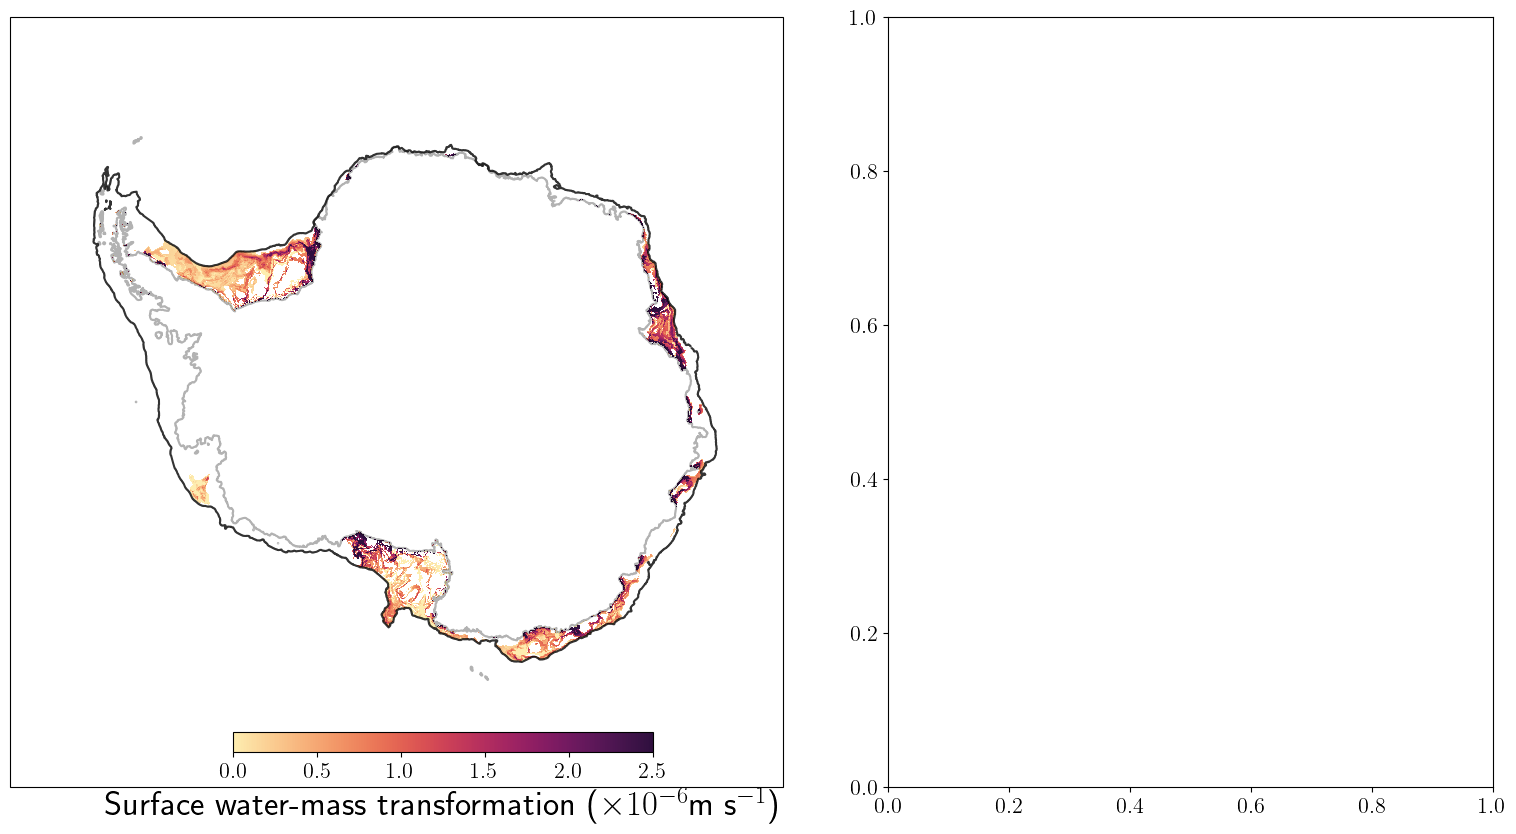

In [30]:
from matplotlib import gridspec
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=16) 
rc('ytick', labelsize=16) 
rc('axes', labelsize=16) 


fig  = plt.figure(1, figsize = (20, 10))
gs = gridspec.GridSpec(1,2, width_ratios = [3, 2]) 
gs.update(wspace = 0.05)

ax, ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo()), plt.subplot(gs[1])

ax.contour(xh, yh,land_mask, [0, 1],
           colors = 'k', alpha = 0.3, transform = ccrs.PlateCarree() )
ax.contour(shelf_mask.xh, shelf_mask.yh, shelf_mask, [0, 1],
           colors='k', alpha =0.8, transform = ccrs.PlateCarree())

norm = col.Normalize(vmin=0, vmax=2.5)

plot_swmt = ax.pcolormesh(swmt_xt, swmt_yt, shelf_subduction_plot_ctrl_324,
                          vmin=0, vmax=2.5, cmap=cmo.matter,transform=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())
# ax.outline_patch.set_visible(False)

cax = fig.add_axes([0.27, 0.145, 0.21, 0.02])
cbar=plt.colorbar(plot_swmt, cax=cax, orientation='horizontal', shrink = 0.5, ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3])
cbar.set_label(r'Surface water-mass transformation ($\times 10^{-6}$m s$^{-1}$)', fontsize = 25)


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 47.92 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


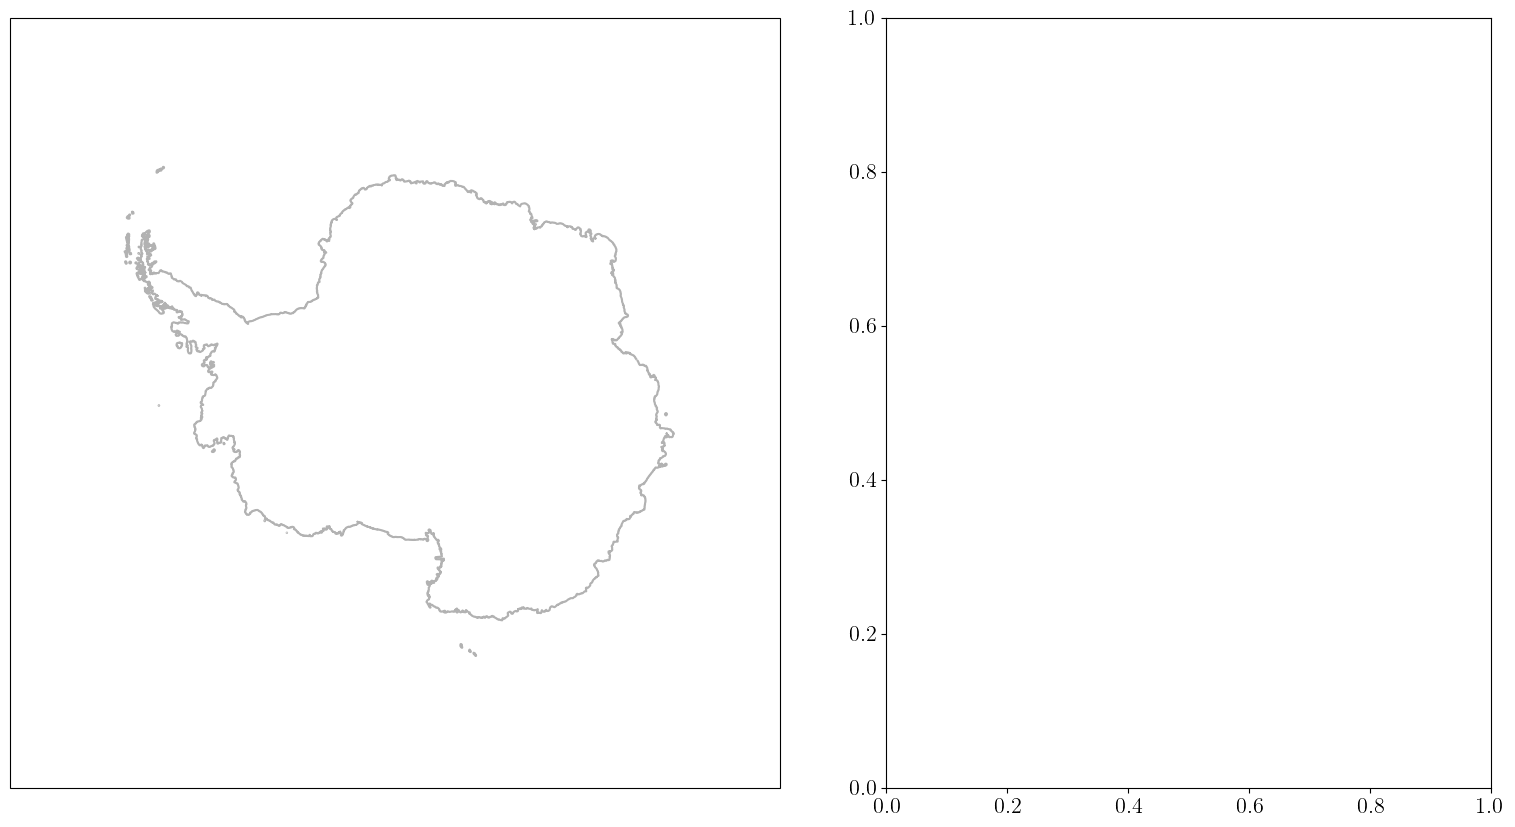

In [31]:
fig  = plt.figure(1, figsize = (20, 10))
gs = gridspec.GridSpec(1,2, width_ratios = [3, 2]) 
gs.update(wspace = 0.05)

ax, ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo()), plt.subplot(gs[1])

ax.contour(xh, yh,land_mask, [0, 1],
           colors = 'k', alpha = 0.3, transform = ccrs.PlateCarree() )

In [32]:
land_mask

<xarray.DataArray 'thkcello' (yh: 1046, xh: 4320)> Size: 18MB
dask.array<mean_agg-aggregate, shape=(1046, 4320), dtype=float32, chunksize=(144, 217), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 35kB -280.0 -279.9 -279.8 -279.7 ... 79.79 79.88 79.96
    zl       float64 8B 0.5413
  * yh       (yh) float64 8kB -86.49 -86.47 -86.45 ... -59.09 -59.05 -59.01